### project praktikum AI: model deteksi motif batik
- Faiz Muzaki - 140810230044
- Kaindra Djoemena - 140810230050
- Nazhifan Zahrawaani - 140810230035


dataset:
- https://huggingface.co/datasets/muhammadsalmanalfaridzi/Batik-Indonesia
- https://www.kaggle.com/datasets/dionisiusdh/indonesian-batik-motifs

google drive mounting

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


project setup & data handling

In [2]:
from PIL import Image, UnidentifiedImageError
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
import timm   # trained with ImageNets database

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [3]:
print(torch.cuda.is_available())

False


In [4]:
# batik dataset class
class BatikDataset(Dataset):
  def __init__(self, data_dir, transform=None):
    self.data = ImageFolder(data_dir, transform=transform)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]

  @property
  def classes(self):
    return self.data.classes

In [5]:
# working directoriestest_dir
train_dir = "/content/drive/MyDrive/batik-detection/dataset/training"
test_dir = "/content/drive/MyDrive/batik-detection/dataset/testing"
valid_dir = "/content/drive/MyDrive/batik-detection/dataset/validation"

In [6]:
ImageNet_mean = [0.485, 0.456, 0.406]
ImageNet_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5), # flips the image horizontally
    transforms.RandomRotation(15),         # rotates the image by up to 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=ImageNet_mean, std=ImageNet_std)
])

val_test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=ImageNet_mean, std=ImageNet_std)
])

# datasets
train_set = BatikDataset(data_dir=train_dir, transform=train_transform)
test_set = BatikDataset(data_dir=test_dir, transform=val_test_transform)
val_set = BatikDataset(data_dir=valid_dir, transform=val_test_transform)

# dataloaders
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

In [7]:
# id-label dict
id_to_class = {v: k for k, v in ImageFolder(train_dir).class_to_idx.items()}
print(id_to_class)

{0: 'Asmat', 1: 'Bali', 2: 'Betawi', 3: 'Boraspati', 4: 'Celup', 5: 'Cendrawasih', 6: 'Ceplok', 7: 'Ciamis', 8: 'Dayak', 9: 'Gajah', 10: 'Garutan', 11: 'Gentongan', 12: 'Insang', 13: 'Jakarta', 14: 'Kawung', 15: 'Keraton', 16: 'Lontara', 17: 'Lumbung', 18: 'Mataketeran', 19: 'Megamendung', 20: 'Pala', 21: 'Parang', 22: 'Pring', 23: 'Rumah_Minang', 24: 'Sekar', 25: 'Sidoluhur', 26: 'Sidomukti', 27: 'Tifa', 28: 'Yogyakarta_Parang'}


model

In [8]:
class BatikClassifier(nn.Module):
  def __init__(self, num_classes=len(id_to_class), dropout_rate=0.5):
    super(BatikClassifier, self).__init__()

    # weights dan bias sudah di-train dengan dataset ImageNet
    self.base_model = timm.create_model("efficientnet_b0", pretrained=True)
    self.features = nn.Sequential(*list(self.base_model.children())[:-1])

    enet_out_size = 1280 # feature size efficientnet_b0

    self.classifier = nn.Sequential(
        nn.Linear(enet_out_size, 512),  # intermediate layer
        nn.ReLU(),                      # relu
        nn.Dropout(dropout_rate),       # regularization
        nn.Linear(512, num_classes)     # output layer
    )

    for param in self.features.parameters():
      param.requires_grad = False

  def forward(self, x):
    x = self.features(x)
    x = torch.flatten(x, 1) #
    output = self.classifier(x)
    return output

In [9]:
model = BatikClassifier()

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

training

In [10]:
# training loop
num_epochs = 7
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = BatikClassifier()
model.to(device)

criterion = nn.CrossEntropyLoss()                       # loss function
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)    # optimizer

for epoch in range(num_epochs):
  # --- training ---
  model.train()
  running_loss = 0.0
  for images, labels in tqdm(train_loader, desc="Training loop"):
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item() * labels.size(0)

  train_loss = running_loss / len(train_loader.dataset)
  train_losses.append(train_loss)

  # --- validation ---
  model.eval()
  running_loss = 0.0
  with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Validation loop"):
      images, labels = images.to(device), labels.to(device)

      outputs = model(images)
      loss = criterion(outputs, labels)
      running_loss += loss.item() * labels.size(0)

  val_loss = running_loss / len(val_loader.dataset)
  val_losses.append(val_loss)

  print(f"epoch {epoch + 1}/{num_epochs} | train loss: {train_loss}, validation loss: {val_loss}")

Training loop:   0%|          | 0/34 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/12 [00:00<?, ?it/s]

epoch 1/7 | train loss: 3.0105237018641824, validation loss: 2.642818215210782


Training loop:   0%|          | 0/34 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/12 [00:00<?, ?it/s]

epoch 2/7 | train loss: 2.2450677450601155, validation loss: 2.2635533677113293


Training loop:   0%|          | 0/34 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/12 [00:00<?, ?it/s]

epoch 3/7 | train loss: 1.8255220768845368, validation loss: 2.127746831171911


Training loop:   0%|          | 0/34 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/12 [00:00<?, ?it/s]

epoch 4/7 | train loss: 1.528407923144622, validation loss: 2.03667000603068


Training loop:   0%|          | 0/34 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/12 [00:00<?, ?it/s]

epoch 5/7 | train loss: 1.3192130935435393, validation loss: 2.0077855897270585


Training loop:   0%|          | 0/34 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/12 [00:00<?, ?it/s]

epoch 6/7 | train loss: 1.1248492784314341, validation loss: 2.011610955474819


Training loop:   0%|          | 0/34 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/12 [00:00<?, ?it/s]

epoch 7/7 | train loss: 1.0794307506593128, validation loss: 1.9473722311997888


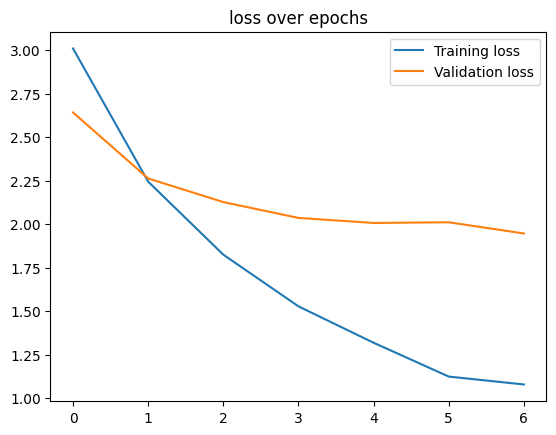

In [11]:
plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.title("loss over epochs")
plt.show()

testing

In [12]:
def preprocess_image(image_path, transform):
  image = Image.open(image_path).convert("RGB")
  return image, transform(image).unsqueeze(0)

def predict(model, image_tensor, device):
  model.eval()
  with torch.no_grad():
    image_tensor = image_tensor.to(device)
    outputs = model(image_tensor)
    probabilities = torch.nn.functional.softmax(outputs, dim=1)
  return probabilities.cpu().numpy().flatten()

def visualize_predictions(original_image, probabilities, class_names):
  fig, axarr = plt.subplots(1, 2, figsize=(12, 6))

  axarr[0].imshow(original_image)
  axarr[0].axis("off")

  axarr[1].barh(class_names, probabilities)
  axarr[1].set_xlabel("Probability")
  axarr[1].set_title("Class Predictions")
  axarr[1].set_xlim(0, 1)

  plt.tight_layout()
  plt.show()


--- Calculating Per-Label Accuracy on Test Set ---


Processing Test Images:   0%|          | 0/378 [00:00<?, ?it/s]


Per-Label Accuracy:
Asmat: 75.00%
Bali: 45.45%
Betawi: 10.00%
Boraspati: 66.67%
Celup: 50.00%
Cendrawasih: 50.00%
Ceplok: 18.18%
Ciamis: 9.09%
Dayak: 63.64%
Gajah: 88.89%
Garutan: 20.00%
Gentongan: 20.00%
Insang: 80.00%
Jakarta: 57.14%
Kawung: 66.67%
Keraton: 20.00%
Lontara: 25.00%
Lumbung: 22.22%
Mataketeran: 75.00%
Megamendung: 79.41%
Pala: 37.50%
Parang: 52.94%
Pring: 37.50%
Rumah_Minang: 22.22%
Sekar: 20.00%
Sidoluhur: 36.36%
Sidomukti: 40.00%
Tifa: 75.00%
Yogyakarta_Parang: 57.89%

Overall Average Accuracy: 49.74%


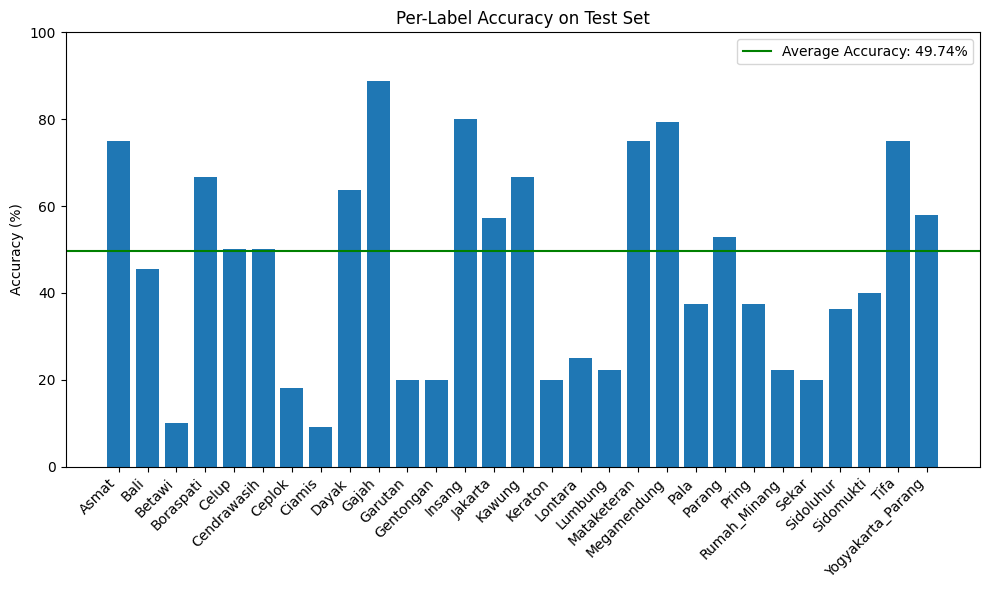

In [13]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm # Using tqdm.auto for better integration

model.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device) # Ensure model is on the correct device

class_names = list(id_to_class.values())
num_classes = len(class_names)

# Initialize lists to store correct and total counts for each class
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))

overall_correct = 0
overall_total = 0

print("\n--- Calculating Per-Label Accuracy on Test Set ---")

# Use tqdm with the total number of samples in the test set
with torch.no_grad():
    with tqdm(total=len(test_set), desc="Processing Test Images") as pbar:
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            # Update overall counts
            overall_total += labels.size(0)
            overall_correct += (predicted == labels).sum().item()

            # Update per-class counts
            for i in range(labels.size(0)):
                label = labels[i]
                prediction = predicted[i]
                class_total[label] += 1
                if prediction == label:
                    class_correct[label] += 1

            pbar.update(images.size(0)) # Update progress bar by the number of images in the batch

# Calculate per-label accuracy
per_label_accuracy = [100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]

# Calculate overall average accuracy
overall_average_accuracy = (overall_correct / overall_total) * 100 if overall_total > 0 else 0

# Print per-label accuracy and overall average accuracy
print("\nPer-Label Accuracy:")
for i in range(num_classes):
    print(f"{class_names[i]}: {per_label_accuracy[i]:.2f}%")
print(f"\nOverall Average Accuracy: {overall_average_accuracy:.2f}%")


# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(class_names, per_label_accuracy)
plt.ylabel("Accuracy (%)")
plt.title("Per-Label Accuracy on Test Set")
plt.xticks(rotation=45, ha="right") # Rotate labels for better readability
plt.ylim(0, 100) # Set y-axis limit from 0 to 100

# Add the average accuracy line
plt.axhline(y=overall_average_accuracy, color='g', linestyle='-', label=f'Average Accuracy: {overall_average_accuracy:.2f}%')
plt.legend() # Show the legend for the average accuracy line

plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

save model

In [16]:
model_path = '/content/drive/MyDrive/batik-detection/pytorch_model.pth'
torch.save(model.state_dict(), model_path)

print(f"madle saved in: {model_path}")

id_to_class = {v: k for k, v in ImageFolder(train_dir).class_to_idx.items()}
class_names = list(id_to_class.values())

print("classes:")
print(class_names)

madle saved in: /content/drive/MyDrive/batik-detection/pytorch_model.pth
classes:
['Asmat', 'Bali', 'Betawi', 'Boraspati', 'Celup', 'Cendrawasih', 'Ceplok', 'Ciamis', 'Dayak', 'Gajah', 'Garutan', 'Gentongan', 'Insang', 'Jakarta', 'Kawung', 'Keraton', 'Lontara', 'Lumbung', 'Mataketeran', 'Megamendung', 'Pala', 'Parang', 'Pring', 'Rumah_Minang', 'Sekar', 'Sidoluhur', 'Sidomukti', 'Tifa', 'Yogyakarta_Parang']
